In [1]:

# import zipfile

# # Specify the zip file path
# zip_file_path = 'Gun_NoGun_Dataset_augmented.zip'

# # Specify the extraction path
# extract_path = '.'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all files
#     zip_ref.extractall(extract_path)

# print(f'Zip file extracted to {extract_path}')

In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

2024-09-13 13:08:44.709093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 13:08:44.726154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 13:08:44.743172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 13:08:44.748315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 13:08:44.760674: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
data_dir =  "UCF_crime_subset/"
IMAGE_HEIGHT, IMAGE_WIDTH= 224,224

SEQUENCE_LENGTH =50

In [6]:
class_categories_list = ["Gun", "NoGun"]
model_output_length = len(class_categories_list)

In [7]:
max_pixel_value = 255
def extract_frame(video_path):
  # frames_list = []

  # #print(" the video file path is : {}".format(video_path))
  # videoObj = cv2.VideoCapture(video_path)
  # #print("the video object is: {}".format(videoObj))

  # """ Iterating through Video Frames """
  # while True:

  #   # Reading a frame from the video file
  #   success, image = videoObj.read()
  #   #print("the value of success is: {}".format(success))

  #   if not success:
  #     break

  #   resized_frame = cv2.resize(image, (image_height, image_width))

  #   """Normalize the resized frame by dividing it with 255 so that 
  #   each pixel value then lies between 0 and 1"""

  #   normalized_frame = resized_frame / max_pixel_value
  #   frames_list.append(normalized_frame)

    
  # videoObj.release()


    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
    
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
    
        if not success:
            break
    
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    
    video_reader.release()


    return frames_list



In [8]:
def data_creation():

    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_categories_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(data_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = extract_frame(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = data_creation()

Extracting Data of Class: Gun
Extracting Data of Class: NoGun


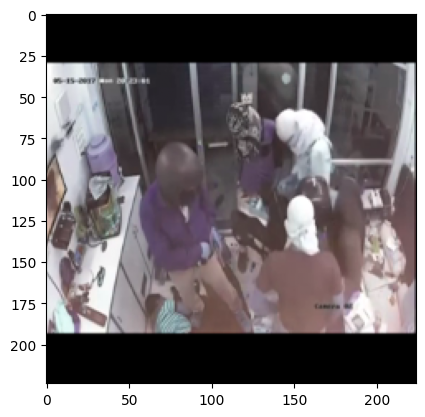

In [10]:
plt.imshow(features[1][40])

In [11]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (100, 50, 224, 224, 3)
the shape of the labels = (100,)


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.5, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [14]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (50, 50, 224, 224, 3)
the shape of the labels = (50, 2)


In [15]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (50, 50, 224, 224, 3)
the shape of the labels = (50, 2)


In [16]:
from tensorflow.keras.models import load_model

no_of_channels = 3

# Load the saved model
VGG_model = load_model('VGG16_Date_Time_2024_08_17__16_23_00___Loss_0.13619327545166016___Accuracy_0.9503968358039856.h5')


# Define the input shape
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, no_of_channels)

# Remove the classification head (last layer)
VGG_model = Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[-5].output)

# Set the new input shape
VGG_model.build(input_shape)

# Print the updated model summary
VGG_model.summary()

2024-09-13 13:10:14.118513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37491 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1a:00.0, compute capability: 8.0
2024-09-13 13:10:14.123603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38365 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
2024-09-13 13:10:14.125901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37747 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3d:00.0, compute capability: 8.0
2024-09-13 13:10:14.128514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 29531 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bu

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
video_input = Input(shape=(SEQUENCE_LENGTH,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [18]:
video_frames_encoded = TimeDistributed(VGG_model)(video_input)

In [19]:
video_frames_encoded

<KerasTensor shape=(None, 50, 512), dtype=float32, sparse=False, name=keras_tensor_49>

In [20]:
no_of_classes = 2

In [21]:

# Define the Transformer model for sequential video frames processing
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    
    # Add & Normalize
    attention_output = Add()([attention_output, inputs])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed-forward part
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    
    # Add & Normalize
    ff_output = Add()([ff_output, attention_output])
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)
    
    return ff_output

In [22]:
# Transformer Encoder
transformer_output = transformer_encoder(video_frames_encoded, head_size=256, num_heads=4, ff_dim=512, dropout=0.1)

# Global pooling layer (optional, depending on your use case)
transformer_output = GlobalAveragePooling1D()(transformer_output)

# Hidden layers (same as before)
hidden_layer1 = Dense(1024, activation="relu")(transformer_output)
hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
hidden_layer4 = Dense(128, activation="relu")(hidden_layer3)
hidden_layer5 = Dense(64, activation="relu")(hidden_layer4)


# Add output layer
outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)


model = Model([video_input], outputs)

In [23]:
optimizer = Adam(learning_rate=0.000005)
                  # beta_1=0.9,
                  # beta_2=0.999,
                  # epsilon=1e-08,
                  # weight_decay=0.004)

In [24]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 50, 512)   │ 14,714,688 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 512)   │  2,100,736 │ time_distributed… │
│ (MultiHeadAttentio… │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 512)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 512)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 512)   │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 512)   │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 512)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 512)   │    262,656 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 512)   │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    525,312 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │        130 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,565,506 (70.82 MB)

 Trainable params: 3,850,818 (14.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=10)
checkpoint = ModelCheckpoint('VGG+Transformer_best_weights(UCF_Crime(50-50)).keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks = [early_stopping_callback, checkpoint]

In [27]:
features_train.shape, labels_train.shape

((50, 50, 224, 224, 3), (50, 2))

In [28]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 150, 
                                   batch_size = 8,
                                   shuffle = True, 
                                   callbacks=[callbacks],
                                   validation_split = 0.2)

Epoch 1/150


I0000 00:00:1726247436.344050 1216202 service.cc:146] XLA service 0x7fda4801d3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726247436.344078 1216202 service.cc:154]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1726247436.344084 1216202 service.cc:154]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1726247436.344086 1216202 service.cc:154]   StreamExecutor device (2): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1726247436.344087 1216202 service.cc:154]   StreamExecutor device (3): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1726247436.344091 1216202 service.cc:154]   StreamExecutor device (4): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1726247436.344093 1216202 service.cc:154]   StreamExecutor device (5): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-09-13 13:10:37.258890: I tensorflow/compiler/mlir/te

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5154 - loss: 0.6995

2024-09-13 13:11:06.948054: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 116 bytes spill stores, 116 bytes spill loads

2024-09-13 13:11:07.060771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 592 bytes spill stores, 400 bytes spill loads

2024-09-13 13:11:14.884528: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill stores, 4 bytes spill loads

2024-09-13 13:11:15.132615: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7898', 8 bytes spill stores, 8 bytes spill loads

2024-09-13 13:11:15.192124: I external/local_xla/xla/stream_executor/


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to VGG+Transformer_best_weights(UCF_Crime(50-50)).keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.5170 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.7025
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5154 - loss: 0.6919
Epoch 2: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.5170 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.7018
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5154 - loss: 0.6839
Epoch 3: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.5170 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5350 - loss: 0.6806
Epoch 4: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.5375 - loss: 0.6809 - val_accuracy: 0.5000 - val_loss: 0.6989
Epoch 5/150

In [29]:
features_test.shape

(50, 50, 224, 224, 3)

In [30]:
# import datetime as dt

# model2_evaluation_history = model.evaluate(features_test, labels_test)

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()

# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
# model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# # Saving your Model
# model.save(model_name)


In [31]:
labels_pred = model.predict(features_test)

2024-09-13 13:16:29.253692: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7849', 4 bytes spill stores, 4 bytes spill loads

2024-09-13 13:16:29.445090: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads

2024-09-13 13:16:29.584291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 16 bytes spill stores, 16 bytes spill loads

2024-09-13 13:16:29.638818: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 24 bytes spill stores, 24 bytes spill loads

2024-09-13 13:16:29.667069: I external/local_xla/xla/stream_executor/cu

1/2 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

2024-09-13 13:16:43.331739: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 16 bytes spill stores, 16 bytes spill loads

2024-09-13 13:16:43.411072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 24 bytes spill stores, 24 bytes spill loads

2024-09-13 13:16:43.414433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7874', 200 bytes spill stores, 200 bytes spill loads

2024-09-13 13:16:43.520960: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 100 bytes spill stores, 100 bytes spill loads

2024-09-13 13:16:43.610482: I external/local_xla/xla/stream_execu

2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 14s/step


In [32]:
labels_pred = np.argmax(labels_pred, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [33]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        26
           1       0.78      0.75      0.77        24

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50



In [34]:
labels_pred_prob = model.predict(features_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()
  plt.show()


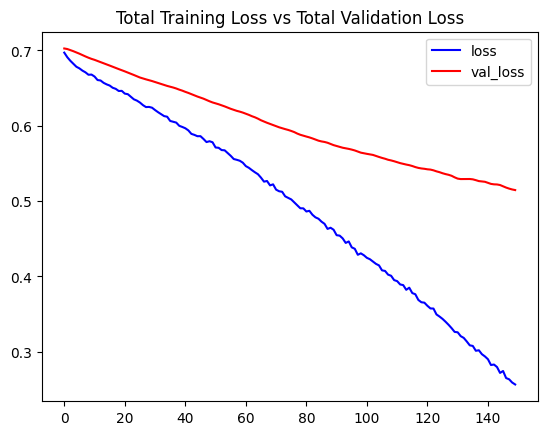

In [36]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

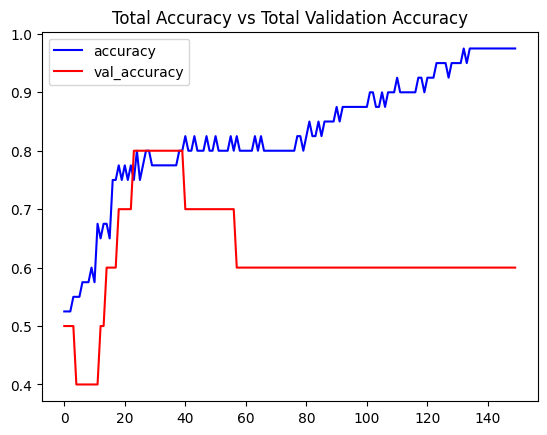

In [37]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [38]:
labels_pred_prob = model.predict(features_test)
labels_pred_prob

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


array([[0.4222123 , 0.5777877 ],
       [0.7523754 , 0.24762456],
       [0.6723135 , 0.32768652],
       [0.14798948, 0.85201055],
       [0.7386505 , 0.26134947],
       [0.2964672 , 0.7035328 ],
       [0.9122835 , 0.08771652],
       [0.37031206, 0.6296879 ],
       [0.23006427, 0.7699357 ],
       [0.35020998, 0.64979005],
       [0.8996963 , 0.10030374],
       [0.08894946, 0.91105056],
       [0.09930399, 0.90069604],
       [0.1931502 , 0.8068498 ],
       [0.6912427 , 0.30875736],
       [0.8133776 , 0.1866224 ],
       [0.8458391 , 0.15416098],
       [0.68241554, 0.3175845 ],
       [0.8638652 , 0.13613476],
       [0.594079  , 0.40592095],
       [0.13417447, 0.86582553],
       [0.48910704, 0.510893  ],
       [0.8988639 , 0.10113602],
       [0.32445136, 0.6755487 ],
       [0.7159104 , 0.28408962],
       [0.53171724, 0.46828273],
       [0.8868972 , 0.11310279],
       [0.21678947, 0.7832106 ],
       [0.60192204, 0.39807796],
       [0.12362771, 0.8763723 ],
       [0.

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)


0.8173076923076923


In [40]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.03846154, 0.03846154,
        0.07692308, 0.07692308, 0.11538462, 0.11538462, 0.19230769,
        0.19230769, 0.26923077, 0.26923077, 0.34615385, 0.34615385,
        0.57692308, 0.57692308, 0.92307692, 0.92307692, 1.        ]),
 array([0.        , 0.04166667, 0.16666667, 0.16666667, 0.29166667,
        0.29166667, 0.33333333, 0.33333333, 0.66666667, 0.66666667,
        0.79166667, 0.79166667, 0.83333333, 0.83333333, 0.875     ,
        0.875     , 0.95833333, 0.95833333, 1.        , 1.        ]),
 array([       inf, 0.91105056, 0.8763723 , 0.86582553, 0.85201055,
        0.8068498 , 0.7832106 , 0.77918315, 0.6296879 , 0.5484852 ,
        0.49804887, 0.49262747, 0.4848562 , 0.40592095, 0.39807796,
        0.28408962, 0.24762456, 0.10113602, 0.10030374, 0.08771652],
       dtype=float32))

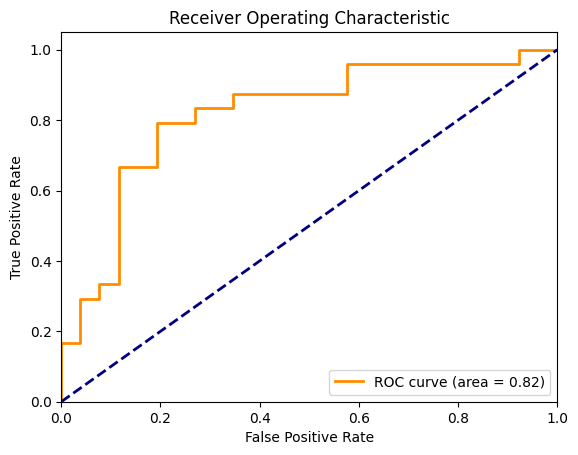

In [41]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()